In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from astropy.io import fits
from astropy import units as u
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

# %%
# Configuration - Update these paths to match your setup
DATA_DIR = Path("/Users/mviero/Repositories/simstack4/src/simstack4/scripts/simstack_test_data")
RESULTS_DIR = DATA_DIR / "results"
CATALOG_FILE = DATA_DIR / "test_catalog.csv"

# Map configurations (should match your test data generator)
MAP_CONFIGS = [
    {'name': 'mips', 'wavelength': 25.0, 'beam_fwhm': 5.0, 'pixel_scale': 1.0},
    {'name': 'pacs_green', 'wavelength': 100.0, 'beam_fwhm': 7.0, 'pixel_scale': 2.0},
    {'name': 'pacs_red', 'wavelength': 160.0, 'beam_fwhm': 10.0, 'pixel_scale': 3.0},
    {'name': 'spire_psw', 'wavelength': 250.0, 'beam_fwhm': 18.0, 'pixel_scale': 6.0},
    {'name': 'spire_plw', 'wavelength': 500.0, 'beam_fwhm': 36.0, 'pixel_scale': 6.0},
    {'name': 'scuba', 'wavelength': 850.0, 'beam_fwhm': 12.0, 'pixel_scale': 2.0}
]

print(f"Data directory: {DATA_DIR}")
print(f"Results directory: {RESULTS_DIR}")
print(f"Catalog file: {CATALOG_FILE}")

Data directory: /Users/mviero/Repositories/simstack4/src/simstack4/scripts/simstack_test_data
Results directory: /Users/mviero/Repositories/simstack4/src/simstack4/scripts/simstack_test_data/results
Catalog file: /Users/mviero/Repositories/simstack4/src/simstack4/scripts/simstack_test_data/test_catalog.csv


In [2]:
def calculate_true_flux_densities_for_populations(catalog, wavelength_um):
    """
    Calculate true flux densities for all sources in catalog
    This creates the baseline for comparison with population-specific calculations
    """
    # Calculate source fluxes (proportional to stellar mass)
    # From your simulation: F ∝ M_star^α, where α ~ 0.8
    alpha = 0.8
    mass_linear = 10 ** catalog['stellar_mass'].values
    base_flux = 1e-4  # Base flux in Jy (from your simulation)
    source_fluxes = base_flux * (mass_linear / 1e10) ** alpha
    
    # Add wavelength-dependent scaling (matches your SED model)
    if wavelength_um <= 200:
        wavelength_factor = (wavelength_um / 100.0) ** 1.5
    else:
        wavelength_factor = (wavelength_um / 100.0) ** 1.5 * np.exp(-(wavelength_um - 200) / 200)
    
    source_fluxes *= wavelength_factor
    
    return source_fluxes

def calculate_expected_flux_for_mass_redshift_bin(mass_min, mass_max, z_min, z_max, wavelength_um):
    """
    Calculate expected flux for a specific mass and redshift bin
    Uses bin centers to represent the population characteristics
    """
    # Use bin centers
    median_mass = (mass_min + mass_max) / 2
    median_redshift = (z_min + z_max) / 2
    
    # Calculate expected flux using same logic as simulation
    alpha = 0.8
    mass_linear = 10 ** median_mass
    base_flux = 1e-4  # Base flux in Jy (from your simulation)
    source_flux = base_flux * (mass_linear / 1e10) ** alpha
    
    # Wavelength scaling (matches your simulation)
    if wavelength_um <= 200:
        wavelength_factor = (wavelength_um / 100.0) ** 1.5
    else:
        wavelength_factor = (wavelength_um / 100.0) ** 1.5 * np.exp(-(wavelength_um - 200) / 200)
    
    source_flux *= wavelength_factor
    
    return source_flux, median_mass, median_redshift

def find_simstack_results(results_dir):
    """Find simstack4 result files"""
    results_files = []
    
    # Look for common simstack4 output patterns
    patterns = [
        "*_summary.csv",
        "*bootstrap*.csv", 
        "results_*.csv",
        "population_summary*.csv"
    ]
    
    for pattern in patterns:
        files = list(results_dir.glob(pattern))
        results_files.extend(files)
    
    return results_files

In [3]:
def load_simstack4_detailed_results(results_dir):
    """
    Load detailed simstack4 results including individual band measurements
    """
    import pickle
    
    # Look for detailed pickle files that contain band-by-band results
    pickle_files = list(results_dir.glob("*detailed*.pkl")) + list(results_dir.glob("*results*.pkl"))
    
    if not pickle_files:
        print("❌ No detailed pickle results found!")
        return None, None
    
    # Use the most recent detailed file
    detailed_file = max(pickle_files, key=lambda x: x.stat().st_mtime)
    print(f"Loading detailed results from: {detailed_file.name}")
    
    try:
        with open(detailed_file, 'rb') as f:
            detailed_results = pickle.load(f)
        
        print("✅ Detailed results loaded successfully")
        print(f"Keys in detailed results: {list(detailed_results.keys())}")
        
        return detailed_results, detailed_file
        
    except Exception as e:
        print(f"❌ Failed to load detailed results: {e}")
        return None, None

In [4]:
# %% [markdown]
# ## 1. Load Test Catalog and Population-Aware Expected Flux Calculation
# Load the test catalog
print("Loading test catalog...")
catalog = pd.read_csv(CATALOG_FILE)
print(f"Catalog loaded: {len(catalog)} sources")
print(f"Columns: {list(catalog.columns)}")
print("\nCatalog summary:")
print(catalog.describe())

# Calculate true flux densities for each wavelength (for reference)
print("\nCalculating reference flux densities for all sources...")
for config in MAP_CONFIGS:
    flux_col = f"true_flux_{config['name']}"
    catalog[flux_col] = calculate_true_flux_densities_for_populations(catalog, config['wavelength'])
    
    print(f"{config['name']} ({config['wavelength']}μm): "
          f"mean={catalog[flux_col].mean():.2e} Jy, "
          f"std={catalog[flux_col].std():.2e} Jy")

# Show how expected flux varies by mass and redshift
print(f"\n📊 Expected flux variation by population bin:")
print(f"{'Mass Bin':<15} {'z Bin':<15} {'100μm':<12} {'160μm':<12} {'250μm':<12} {'500μm':<12}")
print("-" * 75)

# Example calculations for different population bins
mass_bins = [(8.5, 10.0), (10.0, 11.0), (11.0, 12.0)]
z_bins = [(0.1, 1.0), (1.0, 2.0), (2.0, 4.0)]

for mass_min, mass_max in mass_bins:
    for z_min, z_max in z_bins:
        fluxes_str = []
        for config in MAP_CONFIGS:
            flux, _, _ = calculate_expected_flux_for_mass_redshift_bin(
                mass_min, mass_max, z_min, z_max, config['wavelength']
            )
            fluxes_str.append(f"{flux:.1e}")
        
        mass_str = f"{mass_min:.1f}-{mass_max:.1f}"
        z_str = f"{z_min:.1f}-{z_max:.1f}"
        print(f"{mass_str:<15} {z_str:<15} {fluxes_str[0]:<12} {fluxes_str[1]:<12} {fluxes_str[2]:<12} {fluxes_str[3]:<12}")

print(f"\n✅ This shows how expected flux should vary across population bins")
print(f"   • Higher mass bins → higher flux (M*^0.8 scaling)")
print(f"   • Redshift bins → same flux (no k-correction in simulation)")
print(f"   • Longer wavelengths → higher flux (SED shape)")

# %% [markdown]
# ## 2. Load Simstack4 Results
# Find result files
print("Looking for simstack4 results...")
result_files = find_simstack_results(RESULTS_DIR)

if result_files:
    print(f"Found {len(result_files)} result files:")
    for f in result_files:
        print(f"  • {f.name}")
    
    # Use the most recent summary file
    summary_file = max([f for f in result_files if 'summary' in f.name], 
                      key=lambda x: x.stat().st_mtime)
    print(f"\nUsing summary file: {summary_file.name}")
    
    # Load summary results
    results = pd.read_csv(summary_file)
    print(f"Summary results loaded: {len(results)} populations")
    print(f"Summary columns: {list(results.columns)}")
    
else:
    print("❌ No simstack4 summary results found!")
    print(f"Expected location: {RESULTS_DIR}")
    results = None

# Also load detailed results for band-by-band flux measurements
print("\nLooking for detailed simstack4 results...")
detailed_results, detailed_file = load_simstack4_detailed_results(RESULTS_DIR)

if detailed_results:
    print(f"✅ Detailed results loaded from: {detailed_file.name}")
else:
    print("❌ No detailed results found - will have limited analysis capability")

# %% [markdown]
# ## 3. Extract Flux Measurements by Beam Size

# %%


def extract_flux_by_beam(detailed_results, map_configs):
    """
    Extract flux measurements for each beam size from detailed simstack4 results
    """
    if detailed_results is None:
        return None
    
    beam_fluxes = {}
    
    # Navigate to the band results in the detailed structure
    # Try different possible locations for band-by-band flux data
    band_results = None
    raw_results = None
    
    if 'band_results' in detailed_results:
        band_results = detailed_results['band_results']
        print("Found 'band_results' in detailed results")
    elif 'raw_results' in detailed_results:
        raw_results = detailed_results['raw_results']
        print("Found 'raw_results' in detailed results")
        if hasattr(raw_results, 'flux_densities'):
            print("Found flux_densities in raw_results")
        elif hasattr(raw_results, '__dict__'):
            print(f"Raw results attributes: {list(raw_results.__dict__.keys())}")
    
    # Also check if we have processed_results with band_results
    if 'processed_results' in detailed_results:
        processed = detailed_results['processed_results']
        if hasattr(processed, 'band_results'):
            band_results = processed.band_results
            print("Found band_results in processed_results")
    
    # Extract flux data for each map configuration
    for config in map_configs:
        map_name = config['name']
        wavelength = config['wavelength']
        
        flux_data = None
        error_data = None
        population_labels = None
        
        # Method 1: Try band_results dict
        if band_results and map_name in band_results:
            band_data = band_results[map_name]
            print(f"✅ {map_name}: Found in band_results")
            print(f"   Keys: {list(band_data.keys())}")
            
            if 'flux_densities_jy' in band_data:
                flux_data = band_data['flux_densities_jy']
                error_data = band_data.get('flux_errors_jy', np.zeros_like(flux_data))
                population_labels = band_data.get('population_labels', [f'pop_{i}' for i in range(len(flux_data))])
        
        # Method 2: Try raw_results object
        elif raw_results and hasattr(raw_results, 'flux_densities'):
            if map_name in raw_results.flux_densities:
                print(f"✅ {map_name}: Found in raw_results.flux_densities")
                flux_data = raw_results.flux_densities[map_name]
                error_data = raw_results.flux_errors.get(map_name, np.zeros_like(flux_data))
                population_labels = raw_results.population_labels
        
        # Store the extracted data
        if flux_data is not None:
            beam_fluxes[map_name] = {
                'wavelength': wavelength,
                'beam_fwhm': config['beam_fwhm'],
                'flux_densities': np.array(flux_data),
                'flux_errors': np.array(error_data) if error_data is not None else np.zeros_like(flux_data),
                'population_labels': population_labels
            }
            
            print(f"   ✅ Extracted {len(flux_data)} flux measurements")
            print(f"   Flux range: {np.min(flux_data):.2e} to {np.max(flux_data):.2e} Jy")
        else:
            print(f"❌ {map_name}: No flux data found")
            
            # Debug: show what's available
            if band_results:
                print(f"   Available band names: {list(band_results.keys())}")
            if raw_results and hasattr(raw_results, 'flux_densities'):
                print(f"   Available map names in raw results: {list(raw_results.flux_densities.keys())}")
    
    return beam_fluxes

if detailed_results is not None:
    print("Extracting flux measurements by beam size from detailed results...")
    beam_fluxes = extract_flux_by_beam(detailed_results, MAP_CONFIGS)
    
    if beam_fluxes:
        print(f"\nSuccessfully extracted fluxes for {len(beam_fluxes)} beam sizes")
        for map_name, data in beam_fluxes.items():
            print(f"  {map_name}: {len(data['flux_densities'])} measurements")
    else:
        print("❌ Could not extract beam-specific fluxes from detailed results")
        
else:
    print("❌ No detailed results available - cannot extract individual band fluxes")
    beam_fluxes = None

# %% [markdown]
# ## 4. Population-Level Analysis

# %%
def analyze_population_fluxes_detailed(beam_fluxes, catalog, map_configs):
    """
    Analyze flux measurements at the population level using detailed band results
    Compare measured vs expected flux for different populations and beam sizes
    """
    if beam_fluxes is None or len(beam_fluxes) == 0:
        return None
    
    # Create analysis dataframe
    analysis_data = []
    
    # Get all unique population labels across all maps
    all_pop_labels = set()
    for map_data in beam_fluxes.values():
        if map_data['population_labels']:
            all_pop_labels.update(map_data['population_labels'])
    
    print(f"Found {len(all_pop_labels)} unique populations across all maps")
    
    for pop_label in all_pop_labels:
        if pop_label == "foreground":
            continue  # Skip foreground
            
        pop_data = {'population_id': pop_label}
        
        # For each map configuration, get measured flux and calculate expected flux
        for config in map_configs:
            map_name = config['name']
            wavelength = config['wavelength']
            
            if map_name not in beam_fluxes:
                continue
                
            map_data = beam_fluxes[map_name]
            
            # Find this population in the results
            if pop_label in map_data['population_labels']:
                pop_idx = list(map_data['population_labels']).index(pop_label)
                measured_flux = map_data['flux_densities'][pop_idx]
                flux_error = map_data['flux_errors'][pop_idx] if len(map_data['flux_errors']) > pop_idx else 0
                
                pop_data[f'measured_flux_{map_name}'] = measured_flux
                pop_data[f'flux_error_{map_name}'] = flux_error
                pop_data[f'wavelength_{map_name}'] = wavelength
                pop_data[f'beam_fwhm_{map_name}'] = config['beam_fwhm']
                
                # Calculate expected flux for this population
                # We need to estimate population properties from the catalog
                # This is tricky without knowing exactly which sources are in each population
                # We'll make a rough estimate based on the population ID
                
                expected_flux = estimate_expected_flux_for_population(
                    pop_label, catalog, wavelength
                )
                pop_data[f'expected_flux_{map_name}'] = expected_flux
                
                # Calculate bias ratio
                if expected_flux > 0 and measured_flux > 0:
                    pop_data[f'bias_ratio_{map_name}'] = measured_flux / expected_flux
                else:
                    pop_data[f'bias_ratio_{map_name}'] = np.nan
        
        analysis_data.append(pop_data)
    
    return pd.DataFrame(analysis_data)

def estimate_expected_flux_for_population(pop_label, catalog, wavelength_um):
    """
    Estimate expected flux for a population based on its stellar mass and redshift bins
    This properly accounts for the population characteristics
    """
    # Parse population characteristics from the label
    try:
        if '__' in pop_label:
            parts = pop_label.split('__')
            
            # Extract redshift and mass bin information
            z_min = z_max = mass_min = mass_max = None
            
            for part in parts:
                if 'redshift' in part:
                    z_part = part.replace('redshift_', '')
                    z_vals = z_part.split('_')
                    if len(z_vals) >= 2:
                        z_min, z_max = float(z_vals[0]), float(z_vals[1])
                elif 'stellar_mass' in part or 'mass' in part:
                    mass_part = part.replace('stellar_mass_', '').replace('mass_', '')
                    mass_vals = mass_part.split('_')
                    if len(mass_vals) >= 2:
                        mass_min, mass_max = float(mass_vals[0]), float(mass_vals[1])
            
            # Use bin centers if we successfully parsed the population ID
            if z_min is not None and mass_min is not None:
                median_redshift = (z_min + z_max) / 2
                median_mass = (mass_min + mass_max) / 2
                print(f"  Population {pop_label[:30]}...")
                print(f"    z_bin: {z_min:.1f}-{z_max:.1f} (center: {median_redshift:.1f})")
                print(f"    mass_bin: {mass_min:.1f}-{mass_max:.1f} (center: {median_mass:.1f})")
            else:
                # Fallback to catalog medians
                median_redshift = catalog['redshift'].median()
                median_mass = catalog['stellar_mass'].median()
                print(f"  Warning: Could not parse {pop_label}, using catalog medians")
        else:
            # Simple population ID - use catalog medians
            median_redshift = catalog['redshift'].median()
            median_mass = catalog['stellar_mass'].median()
            print(f"  Population {pop_label}: using catalog medians (z={median_redshift:.1f}, M*={median_mass:.1f})")
            
    except Exception as e:
        print(f"  Warning: Error parsing {pop_label}: {e}")
        median_redshift = catalog['redshift'].median()
        median_mass = catalog['stellar_mass'].median()
    
    # Calculate expected flux using same logic as simulation
    alpha = 0.8
    mass_linear = 10 ** median_mass
    base_flux = 1e-4  # Base flux in Jy (from your simulation)
    source_flux = base_flux * (mass_linear / 1e10) ** alpha
    
    # Wavelength scaling (matches your simulation)
    if wavelength_um <= 200:
        wavelength_factor = (wavelength_um / 100.0) ** 1.5
    else:
        wavelength_factor = (wavelength_um / 100.0) ** 1.5 * np.exp(-(wavelength_um - 200) / 200)
    
    source_flux *= wavelength_factor
    
    print(f"    Expected flux at {wavelength_um}μm: {source_flux:.2e} Jy")
    
    # For stacking, this represents the mean flux per source in the population
    return source_flux

Loading test catalog...
Catalog loaded: 150000 sources
Columns: ['ra', 'dec', 'redshift', 'stellar_mass', 'population_type', 'population_label', 'source_id']

Catalog summary:
                  ra            dec       redshift   stellar_mass  \
count  150000.000000  150000.000000  150000.000000  150000.000000   
mean      150.000258       2.000704       0.798380      10.487192   
std         0.288546       0.288683       0.764249       0.790821   
min       149.500006       1.500002       0.100000       8.500000   
25%       149.749729       1.750664       0.229718       9.939082   
50%       150.001401       2.000949       0.553059      10.496546   
75%       150.250369       2.249841       1.105833      11.056282   
max       150.499992       2.499983       4.000000      12.000000   

       population_label      source_id  
count     150000.000000  150000.000000  
mean           0.432700   74999.500000  
std            0.495452   43301.414527  
min            0.000000       0.000000

In [5]:
if beam_fluxes is not None:
    print("Analyzing population-level fluxes from detailed results...")
    pop_analysis = analyze_population_fluxes_detailed(beam_fluxes, catalog, MAP_CONFIGS)
    
    if pop_analysis is not None and len(pop_analysis) > 0:
        print(f"Population analysis complete: {len(pop_analysis)} populations")
        print(f"Analysis columns: {list(pop_analysis.columns)}")
        
        # Show sample of bias ratios
        bias_cols = [col for col in pop_analysis.columns if 'bias_ratio' in col]
        if bias_cols:
            print(f"\nSample bias ratios:")
            for col in bias_cols:
                valid_ratios = pop_analysis[col].dropna()
                if len(valid_ratios) > 0:
                    print(f"  {col}: mean = {valid_ratios.mean():.3f}, std = {valid_ratios.std():.3f}")
    else:
        print("⚠️  Population analysis incomplete")
else:
    print("❌ Cannot analyze populations - no beam flux data available")
    pop_analysis = None

Analyzing population-level fluxes from detailed results...
Found 10 unique populations across all maps
  Population redshift_1.00_2.00__stellar_ma...
    z_bin: 1.0-2.0 (center: 1.5)
    mass_bin: 8.5-10.0 (center: 9.2)
    Expected flux at 25.0μm: 3.14e-06 Jy
  Population redshift_1.00_2.00__stellar_ma...
    z_bin: 1.0-2.0 (center: 1.5)
    mass_bin: 8.5-10.0 (center: 9.2)
    Expected flux at 100.0μm: 2.51e-05 Jy
  Population redshift_1.00_2.00__stellar_ma...
    z_bin: 1.0-2.0 (center: 1.5)
    mass_bin: 8.5-10.0 (center: 9.2)
    Expected flux at 160.0μm: 5.08e-05 Jy
  Population redshift_1.00_2.00__stellar_ma...
    z_bin: 1.0-2.0 (center: 1.5)
    mass_bin: 8.5-10.0 (center: 9.2)
    Expected flux at 250.0μm: 7.73e-05 Jy
  Population redshift_1.00_2.00__stellar_ma...
    z_bin: 1.0-2.0 (center: 1.5)
    mass_bin: 8.5-10.0 (center: 9.2)
    Expected flux at 500.0μm: 6.27e-05 Jy
  Population redshift_1.00_2.00__stellar_ma...
    z_bin: 1.0-2.0 (center: 1.5)
    mass_bin: 8.5-10.0 

In [6]:
def plot_bias_vs_beam_size(pop_analysis, map_configs, beam_fluxes=None):
    """Plot systematic bias as a function of beam size"""
    
    if pop_analysis is None or len(pop_analysis) == 0:
        print("❌ No population analysis data available for plotting")
        return
    
    # Extract bias measurements from the detailed analysis
    beam_sizes = []
    wavelengths = []
    bias_ratios = []
    map_names = []
    measured_fluxes = []
    expected_fluxes = []
    
    for config in map_configs:
        map_name = config['name']
        bias_col = f'bias_ratio_{map_name}'
        measured_col = f'measured_flux_{map_name}'
        expected_col = f'expected_flux_{map_name}'
        
        if bias_col in pop_analysis.columns:
            # Get valid (non-NaN, positive) bias measurements
            valid_mask = (
                pop_analysis[bias_col].notna() & 
                (pop_analysis[bias_col] > 0) &
                (pop_analysis[measured_col] > 0) &
                (pop_analysis[expected_col] > 0)
            )
            
            valid_pops = pop_analysis[valid_mask]
            
            if len(valid_pops) > 0:
                print(f"{map_name}: {len(valid_pops)} valid bias measurements")
                
                beam_sizes.extend([config['beam_fwhm']] * len(valid_pops))
                wavelengths.extend([config['wavelength']] * len(valid_pops))
                bias_ratios.extend(valid_pops[bias_col].values)
                map_names.extend([map_name] * len(valid_pops))
                measured_fluxes.extend(valid_pops[measured_col].values)
                expected_fluxes.extend(valid_pops[expected_col].values)
            else:
                print(f"{map_name}: No valid bias measurements")
    
    if len(bias_ratios) == 0:
        print("❌ No valid bias measurements found for plotting")
        
        # Debug information
        print("\nDebug: Checking for any flux measurements...")
        for config in map_configs:
            map_name = config['name']
            measured_col = f'measured_flux_{map_name}'
            expected_col = f'expected_flux_{map_name}'
            
            if measured_col in pop_analysis.columns:
                measured = pop_analysis[measured_col]
                expected = pop_analysis[expected_col] if expected_col in pop_analysis.columns else None
                
                print(f"{map_name}:")
                print(f"  Measured flux: {measured.describe()}")
                if expected is not None:
                    print(f"  Expected flux: {expected.describe()}")
        return
    
    print(f"Creating plots with {len(bias_ratios)} bias measurements")
    
    # Create DataFrame for plotting
    bias_df = pd.DataFrame({
        'beam_fwhm': beam_sizes,
        'wavelength': wavelengths,
        'bias_ratio': bias_ratios,
        'map_name': map_names,
        'measured_flux': measured_fluxes,
        'expected_flux': expected_fluxes
    })
    
    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Bias ratio vs beam size
    ax1 = axes[0, 0]
    colors = plt.cm.Set1(np.linspace(0, 1, len(map_configs)))
    
    for i, config in enumerate(map_configs):
        mask = bias_df['map_name'] == config['name']
        if mask.sum() > 0:
            data = bias_df[mask]
            ax1.scatter(data['beam_fwhm'], data['bias_ratio'], 
                       label=f"{config['name']} ({config['wavelength']:.0f}μm)",
                       alpha=0.7, s=80, color=colors[i])
    
    ax1.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='No bias')
    ax1.set_xlabel('Beam FWHM (arcsec)')
    ax1.set_ylabel('Measured / Expected Flux')
    ax1.set_title('Flux Bias vs. Beam Size')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Bias ratio vs wavelength
    ax2 = axes[0, 1]
    for i, config in enumerate(map_configs):
        mask = bias_df['map_name'] == config['name']
        if mask.sum() > 0:
            data = bias_df[mask]
            ax2.scatter(data['wavelength'], data['bias_ratio'],
                       label=f"FWHM={config['beam_fwhm']}\"",
                       alpha=0.7, s=80, color=colors[i])
    
    ax2.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='No bias')
    ax2.set_xlabel('Wavelength (μm)')
    ax2.set_ylabel('Measured / Expected Flux')
    ax2.set_title('Flux Bias vs. Wavelength')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xscale('log')
    
    # Plot 3: Distribution of bias ratios
    ax3 = axes[1, 0]
    n_bins = min(30, len(bias_ratios) // 3)  # Adaptive number of bins
    ax3.hist(bias_ratios, bins=n_bins, alpha=0.7, edgecolor='black')
    ax3.axvline(x=1.0, color='red', linestyle='--', alpha=0.7, label='No bias')
    ax3.axvline(x=np.median(bias_ratios), color='orange', linestyle='-', 
                label=f'Median = {np.median(bias_ratios):.3f}')
    ax3.set_xlabel('Measured / Expected Flux')
    ax3.set_ylabel('Number of Population Measurements')
    ax3.set_title('Distribution of Bias Ratios')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Mean bias by beam size with error bars
    ax4 = axes[1, 1]
    beam_stats = bias_df.groupby('beam_fwhm')['bias_ratio'].agg(['mean', 'std', 'count'])
    
    x = beam_stats.index
    y = beam_stats['mean']
    yerr = beam_stats['std'] / np.sqrt(beam_stats['count'])  # Standard error
    
    ax4.errorbar(x, y, yerr=yerr, marker='o', capsize=5, capthick=2, 
                 linewidth=2, markersize=8, color='darkblue')
    ax4.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='No bias')
    ax4.set_xlabel('Beam FWHM (arcsec)')
    ax4.set_ylabel('Mean Bias Ratio ± SE')
    ax4.set_title('Mean Bias vs. Beam Size')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Add wavelength labels to points
    for beam_fwhm in x:
        mask = bias_df['beam_fwhm'] == beam_fwhm
        if mask.sum() > 0:
            wavelength = bias_df[mask]['wavelength'].iloc[0]
            y_pos = beam_stats.loc[beam_fwhm, 'mean']
            ax4.annotate(f'{wavelength:.0f}μm', 
                        xy=(beam_fwhm, y_pos), 
                        xytext=(5, 10), textcoords='offset points',
                        fontsize=9, alpha=0.7)
    
    plt.suptitle('Simstack4 Beam Size Bias Analysis', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("BIAS ANALYSIS SUMMARY")
    print("="*60)
    
    print(f"Total measurements: {len(bias_ratios)}")
    print(f"Overall median bias: {np.median(bias_ratios):.4f}")
    print(f"Overall mean bias: {np.mean(bias_ratios):.4f} ± {np.std(bias_ratios):.4f}")
    
    print("\nBias by beam size:")
    print("-" * 50)
    for beam_size in sorted(bias_df['beam_fwhm'].unique()):
        mask = bias_df['beam_fwhm'] == beam_size
        ratios = bias_df.loc[mask, 'bias_ratio']
        wavelength = bias_df.loc[mask, 'wavelength'].iloc[0]

In [7]:
# %% [markdown]
# ## 8. SED Grid Plot for Simulation Results

# %%
def create_simulation_sed_grid_plot(pop_analysis, 
                                   beam_fluxes,
                                   map_configs,
                                   figsize=(16, 12),
                                   show_errors=True):
    """
    Create grid plot of SEDs comparing expected vs measured flux densities
    
    Parameters:
    -----------
    pop_analysis : pandas.DataFrame
        Population analysis with expected and measured fluxes
    beam_fluxes : dict
        Detailed flux measurements by beam size
    map_configs : list
        Map configuration information
    figsize : tuple
        Figure size (width, height)
    show_errors : bool
        Whether to show error bars
    """
    
    if pop_analysis is None or len(pop_analysis) == 0:
        print("❌ No population analysis data available")
        return None
    
    # Get wavelengths from map configs
    wavelengths = np.array([config['wavelength'] for config in map_configs])
    map_names = [config['name'] for config in map_configs]
    beam_sizes = [config['beam_fwhm'] for config in map_configs]
    
    print(f"📡 Available wavelengths: {wavelengths} μm")
    print(f"📏 Beam sizes: {beam_sizes} arcsec")
    
    # Filter for populations with at least some flux measurements
    valid_pops = []
    for _, pop in pop_analysis.iterrows():
        has_measurements = False
        for map_name in map_names:
            measured_col = f'measured_flux_{map_name}'
            expected_col = f'expected_flux_{map_name}'
            if (measured_col in pop_analysis.columns and 
                expected_col in pop_analysis.columns and
                pop[measured_col] > 0 and pop[expected_col] > 0):
                has_measurements = True
                break
        if has_measurements:
            valid_pops.append(pop)
    
    if len(valid_pops) == 0:
        print("❌ No valid populations with flux measurements found")
        return None
    
    print(f"📊 Found {len(valid_pops)} populations with valid measurements")
    
    # Parse population information from IDs
    def parse_simulation_population_id(pop_id):
        """Parse redshift and mass bins from population ID"""
        try:
            # Handle different population ID formats
            if '__' in pop_id:
                parts = pop_id.split('__')
                
                # Look for redshift and mass information
                z_min = z_max = mass_min = mass_max = np.nan
                
                for part in parts:
                    if 'redshift' in part:
                        z_part = part.replace('redshift_', '')
                        z_vals = z_part.split('_')
                        if len(z_vals) >= 2:
                            z_min, z_max = float(z_vals[0]), float(z_vals[1])
                    elif 'stellar_mass' in part or 'mass' in part:
                        mass_part = part.replace('stellar_mass_', '').replace('mass_', '')
                        mass_vals = mass_part.split('_')
                        if len(mass_vals) >= 2:
                            mass_min, mass_max = float(mass_vals[0]), float(mass_vals[1])
                
                return z_min, z_max, mass_min, mass_max
            else:
                # Simple population ID - assign default bins
                return 0.1, 2.0, 9.0, 12.0
                
        except Exception as e:
            print(f"Warning: Could not parse population ID '{pop_id}': {e}")
            return np.nan, np.nan, np.nan, np.nan
    
    # Parse all populations
    pop_data = []
    for pop in valid_pops:
        z_min, z_max, mass_min, mass_max = parse_simulation_population_id(pop['population_id'])
        
        pop_info = {
            'population_id': pop['population_id'],
            'z_min': z_min, 'z_max': z_max,
            'mass_min': mass_min, 'mass_max': mass_max,
            'z_center': (z_min + z_max) / 2,
            'mass_center': (mass_min + mass_max) / 2
        }
        
        # Add flux measurements
        for map_name in map_names:
            measured_col = f'measured_flux_{map_name}'
            expected_col = f'expected_flux_{map_name}'
            error_col = f'flux_error_{map_name}'
            
            pop_info[f'measured_{map_name}'] = pop.get(measured_col, 0)
            pop_info[f'expected_{map_name}'] = pop.get(expected_col, 0)
            pop_info[f'error_{map_name}'] = pop.get(error_col, 0)
        
        if not (np.isnan(z_min) or np.isnan(mass_min)):
            pop_data.append(pop_info)
    
    if len(pop_data) == 0:
        print("❌ No populations with valid bin information")
        return None
    
    pop_df = pd.DataFrame(pop_data)
    
    # Create bins for grid
    z_bins = sorted(pop_df['z_min'].unique())
    mass_bins = sorted(pop_df['mass_min'].unique())
    
    print(f"📊 Grid dimensions: {len(z_bins)} redshift × {len(mass_bins)} mass bins")
    print(f"🔍 Redshift bins: {z_bins}")
    print(f"⭐ Mass bins: {mass_bins}")
    
    # Create the plot
    fig, axes = plt.subplots(len(mass_bins), len(z_bins), figsize=figsize, 
                           sharex=True, sharey=True)
    
    # Handle single row/column cases
    if len(z_bins) == 1 and len(mass_bins) == 1:
        axes = np.array([[axes]])
    elif len(z_bins) == 1:
        axes = axes.reshape(1, -1)
    elif len(mass_bins) == 1:
        axes = axes.reshape(-1, 1)
    
    # Colors
    expected_color = 'blue'
    measured_color = 'red'
    
    # Plot each panel
    for i, mass_min in enumerate(mass_bins):
        for j, z_min in enumerate(z_bins):
            ax = axes[i, j] if len(mass_bins) > 1 and len(z_bins) > 1 else \
                 axes[i] if len(z_bins) == 1 else \
                 axes[j] if len(mass_bins) == 1 else axes
            
            # Find population for this bin
            pop_mask = (pop_df['z_min'] == z_min) & (pop_df['mass_min'] == mass_min)
            bin_pops = pop_df[pop_mask]
            
            if len(bin_pops) == 0:
                # No data for this bin
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
                       transform=ax.transAxes, fontsize=10, alpha=0.5)
            else:
                # Plot SED for this bin (take first population if multiple)
                pop = bin_pops.iloc[0]
                
                expected_fluxes = []
                measured_fluxes = []
                flux_errors = []
                valid_wavelengths = []
                
                for k, map_name in enumerate(map_names):
                    expected = pop[f'expected_{map_name}']
                    measured = pop[f'measured_{map_name}']
                    error = pop[f'error_{map_name}']
                    
                    if expected > 0 and measured > 0:  # Only plot valid measurements
                        expected_fluxes.append(expected * 1e3)  # Convert to mJy
                        measured_fluxes.append(measured * 1e3)  # Convert to mJy
                        flux_errors.append(error * 1e3)  # Convert to mJy
                        valid_wavelengths.append(wavelengths[k])
                
                if len(expected_fluxes) > 0:
                    expected_fluxes = np.array(expected_fluxes)
                    measured_fluxes = np.array(measured_fluxes)
                    flux_errors = np.array(flux_errors)
                    valid_wavelengths = np.array(valid_wavelengths)
                    
                    # Sort by wavelength
                    sort_idx = np.argsort(valid_wavelengths)
                    expected_fluxes = expected_fluxes[sort_idx]
                    measured_fluxes = measured_fluxes[sort_idx]
                    flux_errors = flux_errors[sort_idx]
                    valid_wavelengths = valid_wavelengths[sort_idx]
                    
                    # Plot expected fluxes (open circles)
                    ax.plot(valid_wavelengths, expected_fluxes, 'o', 
                           color=expected_color, fillstyle='none', markersize=8, 
                           markeredgewidth=2, label='Expected', alpha=0.8)
                    
                    # Connect expected points with dashed line
                    if len(expected_fluxes) > 1:
                        ax.plot(valid_wavelengths, expected_fluxes, '--', 
                               color=expected_color, alpha=0.5, linewidth=1)
                    
                    # Plot measured fluxes (closed circles)
                    if show_errors and np.any(flux_errors > 0):
                        ax.errorbar(valid_wavelengths, measured_fluxes, 
                                   yerr=flux_errors,
                                   fmt='o', color=measured_color, alpha=0.8, 
                                   markersize=8, capsize=3, linewidth=1.5, 
                                   label='Measured')
                    else:
                        ax.plot(valid_wavelengths, measured_fluxes, 'o', 
                               color=measured_color, alpha=0.8, markersize=8,
                               label='Measured')
                    
                    # Connect measured points with solid line
                    if len(measured_fluxes) > 1:
                        ax.plot(valid_wavelengths, measured_fluxes, '-', 
                               color=measured_color, alpha=0.5, linewidth=1)
                    
                    # Calculate and display bias ratios
                    bias_ratios = measured_fluxes / expected_fluxes
                    mean_bias = np.mean(bias_ratios)
                    
                    # Add bias information
                    bias_text = f"Bias: {mean_bias:.2f}"
                    ax.text(0.05, 0.15, bias_text, transform=ax.transAxes,
                           fontsize=9, bbox=dict(boxstyle='round,pad=0.3', 
                           facecolor='yellow' if abs(mean_bias - 1) > 0.1 else 'lightgreen', 
                           alpha=0.8))
                
                # Add population info text
                z_center = pop['z_center']
                mass_center = pop['mass_center']
                
                info_text = f"z={z_center:.1f}\nlog M*={mass_center:.1f}"
                ax.text(0.05, 0.95, info_text, transform=ax.transAxes, 
                       fontsize=9, verticalalignment='top',
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
            
            # Set log scales
            ax.set_xscale('log')
            ax.set_yscale('log')
            
            # Set limits based on simulation data
            ax.set_xlim(10, 1000)  # Wavelength range from your simulation
            ax.set_ylim(0.001, 100)  # Flux range in mJy
            
            # Grid
            ax.grid(True, alpha=0.3)
            
            # Labels for edge panels
            if i == len(mass_bins) - 1:  # Bottom row
                ax.set_xlabel('Wavelength (μm)')
            if j == 0:  # Left column
                ax.set_ylabel('Flux Density (mJy)')
            
            # Title for top row (redshift bins)
            if i == 0:
                z_range = f"{z_min:.1f}"
                if j < len(z_bins) - 1:
                    z_next = z_bins[j+1] if j+1 < len(z_bins) else z_min + 1
                    z_range += f"-{z_next:.1f}"
                else:
                    z_range += "+"
                ax.set_title(f"z = {z_range}", fontsize=11, fontweight='bold')
            
            # Mass labels on right
            if j == len(z_bins) - 1:
                mass_range = f"{mass_min:.1f}"
                if i < len(mass_bins) - 1:
                    mass_next = mass_bins[i+1] if i+1 < len(mass_bins) else mass_min + 1
                    mass_range += f"-{mass_next:.1f}"
                else:
                    mass_range += "+"
                
                # Add text on right side
                ax.text(1.05, 0.5, f"log M* = {mass_range}", rotation=270, 
                       transform=ax.transAxes, va='center', ha='left',
                       fontweight='bold', fontsize=10)
    
    # Add legend
    if len(valid_pops) > 0:
        # Create legend elements
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color=expected_color, fillstyle='none',
                   markeredgewidth=2, markersize=8, linestyle='--', alpha=0.8,
                   label='Expected (Simulation Input)'),
            Line2D([0], [0], marker='o', color=measured_color, fillstyle='full',
                   markersize=8, linestyle='-', alpha=0.8,
                   label='Measured (Simstack4 Output)')
        ]
        
        fig.legend(handles=legend_elements, loc='upper center', 
                  bbox_to_anchor=(0.5, 0.98), ncol=2, fontsize=12)
    
    # Overall title
    fig.suptitle('Simstack4 Simulation Test: Expected vs Measured Flux Densities\n'
                'Beam Size Bias Analysis Across Population Bins', 
                fontsize=14, fontweight='bold', y=0.95)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90, hspace=0.2, wspace=0.15)
    
    # Print summary
    print(f"\n📈 SED Grid Plot Summary:")
    print(f"   • {len(mass_bins)} × {len(z_bins)} population bins")
    print(f"   • {len(map_configs)} wavelength bands")
    print(f"   • Blue open circles: Expected flux (simulation input)")
    print(f"   • Red closed circles: Measured flux (simstack4 output)")
    print(f"   • Yellow boxes: Significant bias detected (>10%)")
    print(f"   • Green boxes: Good agreement (<10% bias)")
    
    return fig

In [8]:
# %% [markdown]
# ## 6. Detailed Debug Information

# %%
def print_debug_info(catalog, results, map_configs):
    """Print detailed debugging information"""
    
    print("="*60)
    print("DETAILED DEBUG INFORMATION")
    print("="*60)
    
    print(f"\n1. CATALOG INFO:")
    print(f"   • File: {CATALOG_FILE}")
    print(f"   • Sources: {len(catalog)}")
    print(f"   • Redshift range: {catalog['redshift'].min():.2f} - {catalog['redshift'].max():.2f}")
    print(f"   • Mass range: {catalog['stellar_mass'].min():.1f} - {catalog['stellar_mass'].max():.1f}")
    
    print(f"\n2. MAP CONFIGURATIONS:")
    for config in map_configs:
        print(f"   • {config['name']}: {config['wavelength']}μm, FWHM={config['beam_fwhm']}\"")
        
        # Check if signal/noise maps exist
        signal_file = DATA_DIR / f"{config['name']}_signal.fits"
        noise_file = DATA_DIR / f"{config['name']}_noise.fits"
        
        print(f"     Signal map: {'✅' if signal_file.exists() else '❌'} {signal_file}")
        print(f"     Noise map:  {'✅' if noise_file.exists() else '❌'} {noise_file}")
    
    if results is not None:
        print(f"\n3. SIMSTACK4 RESULTS:")
        print(f"   • File: {summary_file}")
        print(f"   • Populations: {len(results)}")
        print(f"   • Columns: {len(results.columns)}")
        
        print(f"\n   Available columns:")
        for col in sorted(results.columns):
            print(f"     • {col}")
        
        # Check for flux-like columns
        flux_cols = [col for col in results.columns if 
                    any(keyword in col.lower() for keyword in 
                        ['flux', 'luminosity', 'ir', 'jy', 'mjy'])]
        
        print(f"\n   Potential flux columns:")
        for col in flux_cols:
            non_zero = (results[col] > 0).sum() if results[col].dtype in ['float64', 'int64'] else 0
            print(f"     • {col}: {non_zero} non-zero values")
    
    else:
        print(f"\n3. SIMSTACK4 RESULTS:")
        print(f"   ❌ No results file found in {RESULTS_DIR}")
        
        # List what files are actually there
        if RESULTS_DIR.exists():
            files = list(RESULTS_DIR.glob("*"))
            print(f"   Files in results directory:")
            for f in files:
                print(f"     • {f.name}")
        else:
            print(f"   Results directory doesn't exist: {RESULTS_DIR}")
    
    print(f"\n4. NEXT STEPS:")
    if results is None:
        print("   1. Run simstack4 with your test configuration")
        print("   2. Check that results are saved to the expected location")
        print("   3. Verify the output format matches expectations")
    else:
        print("   1. Check if flux column names match your expectations")
        print("   2. Verify population definitions are correct")
        print("   3. Run the bias analysis plots above")

# Print debug information
print_debug_info(catalog, results if 'results' in locals() else None, MAP_CONFIGS)

DETAILED DEBUG INFORMATION

1. CATALOG INFO:
   • File: /Users/mviero/Repositories/simstack4/src/simstack4/scripts/simstack_test_data/test_catalog.csv
   • Sources: 150000
   • Redshift range: 0.10 - 4.00
   • Mass range: 8.5 - 12.0

2. MAP CONFIGURATIONS:
   • mips: 25.0μm, FWHM=5.0"
     Signal map: ✅ /Users/mviero/Repositories/simstack4/src/simstack4/scripts/simstack_test_data/mips_signal.fits
     Noise map:  ✅ /Users/mviero/Repositories/simstack4/src/simstack4/scripts/simstack_test_data/mips_noise.fits
   • pacs_green: 100.0μm, FWHM=7.0"
     Signal map: ✅ /Users/mviero/Repositories/simstack4/src/simstack4/scripts/simstack_test_data/pacs_green_signal.fits
     Noise map:  ✅ /Users/mviero/Repositories/simstack4/src/simstack4/scripts/simstack_test_data/pacs_green_noise.fits
   • pacs_red: 160.0μm, FWHM=10.0"
     Signal map: ✅ /Users/mviero/Repositories/simstack4/src/simstack4/scripts/simstack_test_data/pacs_red_signal.fits
     Noise map:  ✅ /Users/mviero/Repositories/simstack4/src

EXAMPLE: Using create_simulation_sed_grid_plot
✅ Population analysis data available
   • 9 populations found
   • Columns: ['population_id', 'measured_flux_mips', 'flux_error_mips', 'wavelength_mips', 'beam_fwhm_mips', 'expected_flux_mips', 'bias_ratio_mips', 'measured_flux_pacs_green', 'flux_error_pacs_green', 'wavelength_pacs_green', 'beam_fwhm_pacs_green', 'expected_flux_pacs_green', 'bias_ratio_pacs_green', 'measured_flux_pacs_red', 'flux_error_pacs_red', 'wavelength_pacs_red', 'beam_fwhm_pacs_red', 'expected_flux_pacs_red', 'bias_ratio_pacs_red', 'measured_flux_spire_psw', 'flux_error_spire_psw', 'wavelength_spire_psw', 'beam_fwhm_spire_psw', 'expected_flux_spire_psw', 'bias_ratio_spire_psw', 'measured_flux_spire_plw', 'flux_error_spire_plw', 'wavelength_spire_plw', 'beam_fwhm_spire_plw', 'expected_flux_spire_plw', 'bias_ratio_spire_plw', 'measured_flux_scuba', 'flux_error_scuba', 'wavelength_scuba', 'beam_fwhm_scuba', 'expected_flux_scuba', 'bias_ratio_scuba']

📊 Sample populatio

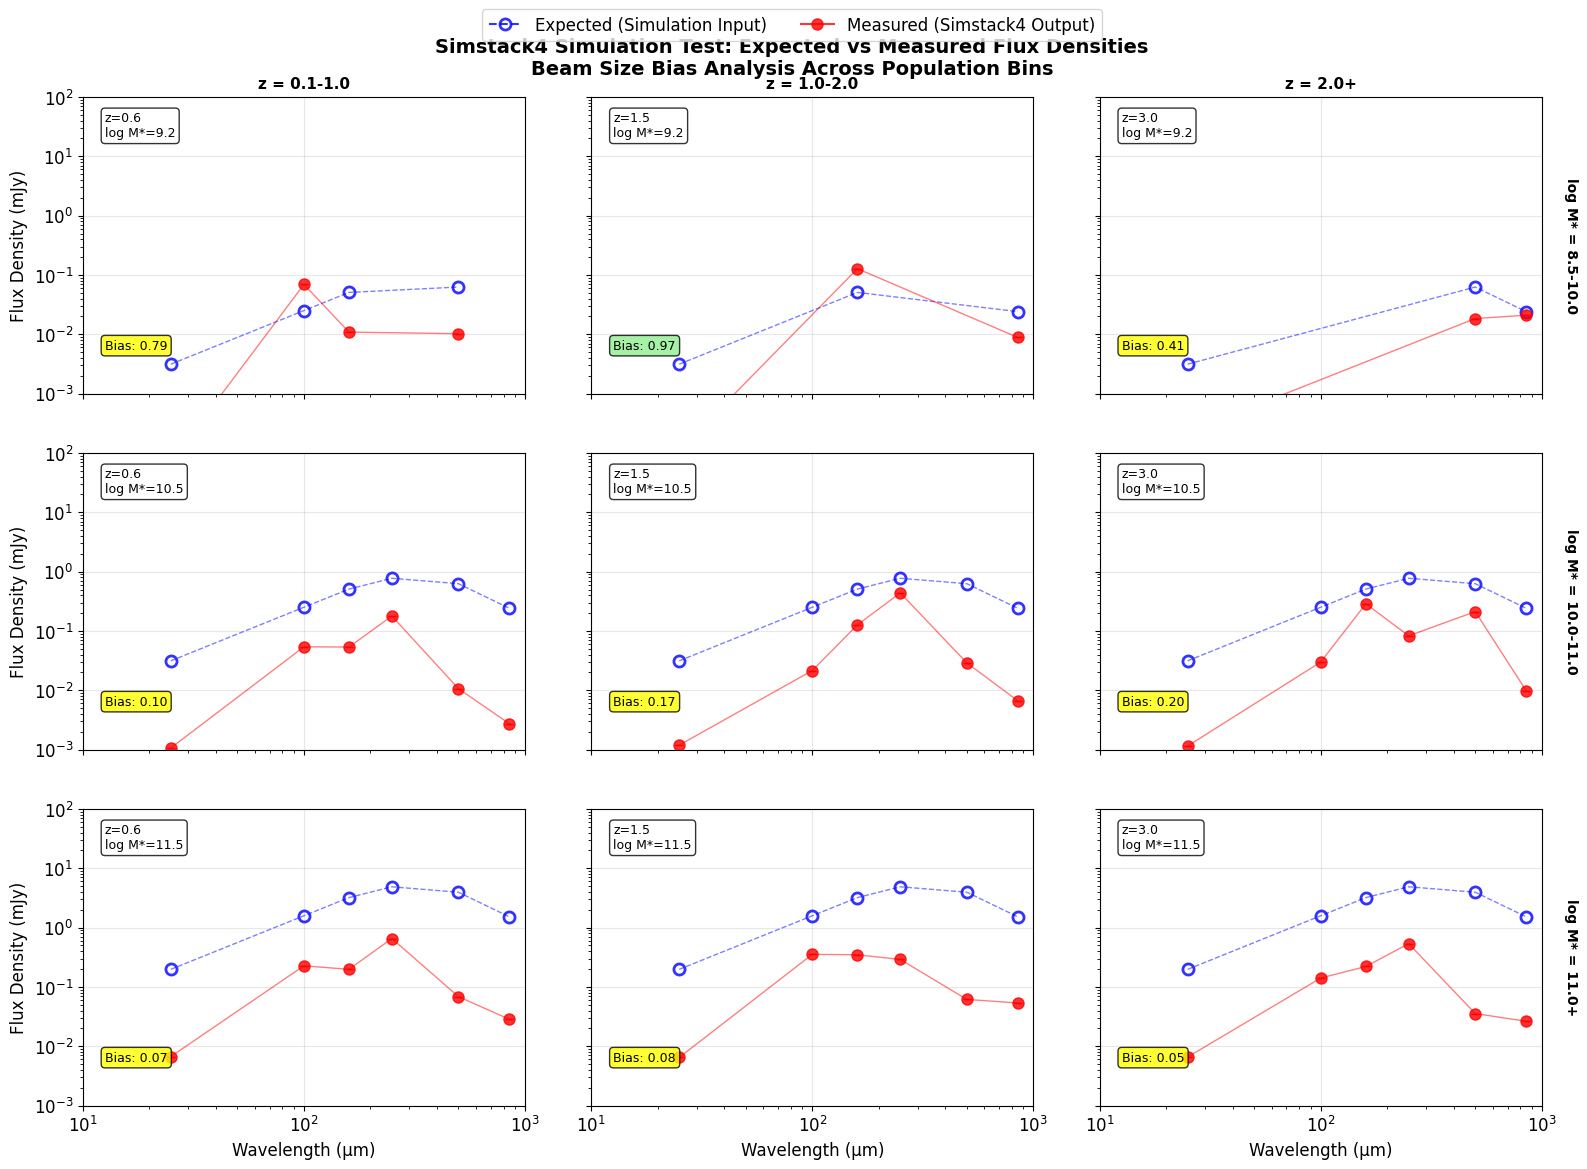

In [9]:
# %% [markdown]
# ## 9. Example Usage of SED Grid Plot

# %%
# Example: How to use create_simulation_sed_grid_plot with your simulation results

print("="*60)
print("EXAMPLE: Using create_simulation_sed_grid_plot")
print("="*60)

# Check if we have the required data
if 'pop_analysis' in locals() and pop_analysis is not None:
    print("✅ Population analysis data available")
    print(f"   • {len(pop_analysis)} populations found")
    print(f"   • Columns: {list(pop_analysis.columns)}")
    
    # Show sample of the data structure
    print(f"\n📊 Sample population data:")
    for i, (idx, pop) in enumerate(pop_analysis.head(3).iterrows()):
        print(f"\nPopulation {i+1}: {pop['population_id']}")
        
        # Show flux measurements for each map
        for config in MAP_CONFIGS:
            map_name = config['name']
            measured_col = f'measured_flux_{map_name}'
            expected_col = f'expected_flux_{map_name}'
            bias_col = f'bias_ratio_{map_name}'
            
            if measured_col in pop_analysis.columns:
                measured = pop[measured_col]
                expected = pop[expected_col] if expected_col in pop_analysis.columns else 0
                bias = pop[bias_col] if bias_col in pop_analysis.columns else np.nan
                
                print(f"  {map_name} ({config['wavelength']}μm, FWHM={config['beam_fwhm']}\"):")
                print(f"    Expected: {expected:.2e} Jy")
                print(f"    Measured: {measured:.2e} Jy")
                print(f"    Bias ratio: {bias:.3f}")
    
    # Check if we have beam_fluxes
    if 'beam_fluxes' in locals() and beam_fluxes is not None:
        print(f"\n✅ Beam flux data available")
        print(f"   • {len(beam_fluxes)} maps with detailed flux measurements")
        
        # Show beam_fluxes structure
        for map_name, data in beam_fluxes.items():
            print(f"   • {map_name}: {len(data['flux_densities'])} population measurements")
    else:
        print(f"\n⚠️  Beam flux data not available - will use simplified version")
        beam_fluxes = None
    
    print(f"\n🎯 Creating SED grid plot...")
    print(f"   This will show:")
    print(f"   • Blue open circles (○): Expected flux from simulation input")
    print(f"   • Red closed circles (●): Measured flux from simstack4 output") 
    print(f"   • Grid organized by redshift (columns) × stellar mass (rows)")
    print(f"   • Bias ratios displayed for each population")
    
    # Create the plot
    try:
        sed_fig = create_simulation_sed_grid_plot(
            pop_analysis=pop_analysis,
            beam_fluxes=beam_fluxes, 
            map_configs=MAP_CONFIGS,
            figsize=(16, 12),
            show_errors=True
        )
        
        if sed_fig is not None:
            print(f"\n✅ SED grid plot created successfully!")
            print(f"   • Look for systematic differences between blue and red points")
            print(f"   • Yellow boxes indicate populations with >10% bias")
            print(f"   • Green boxes indicate good agreement (<10% bias)")
            
            # Save the plot if desired
            # sed_fig.savefig('simulation_sed_grid.png', dpi=300, bbox_inches='tight')
            # print(f"   • Plot saved as 'simulation_sed_grid.png'")
            
        else:
            print(f"\n❌ Failed to create SED grid plot")
            
    except Exception as e:
        print(f"\n❌ Error creating SED grid plot: {e}")
        import traceback
        traceback.print_exc()

else:
    print("❌ Population analysis data not available")
    print("\nTo use create_simulation_sed_grid_plot, you need:")
    print("1. pop_analysis DataFrame with expected and measured flux columns")
    print("2. beam_fluxes dict with detailed flux measurements (optional)")
    print("3. MAP_CONFIGS list with wavelength and beam size info")
    print("\nMake sure to run the earlier analysis steps first!")